In [1]:
# # Code to convert this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvert Train_with_autoencoder_MLPMixer.ipynb --to python"
# call(command,shell=True)

# Import packages & functions

In [2]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm

import webdataset as wds
import gc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

from accelerate import Accelerator, DeepSpeedPlugin

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

In [3]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1

# ## UNCOMMENT BELOW SECTION AND COMMENT OUT DEEPSPEED SECTION TO AVOID USING DEEPSPEED ###
# accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
# global_batch_size = batch_size = 128
# data_type = torch.float16 # change depending on your mixed_precision

### DEEPSPEED INITIALIZATION ###
if num_devices <= 1 and utils.is_interactive():
    global_batch_size = batch_size = 128
    print(f"Setting batch_size to {batch_size}")
    # can emulate a distributed environment for deepspeed to work in jupyter notebook
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = str(np.random.randint(10000)+9000)
    os.environ["RANK"] = "0"
    os.environ["LOCAL_RANK"] = "0"
    os.environ["WORLD_SIZE"] = "1"
    os.environ["GLOBAL_BATCH_SIZE"] = str(global_batch_size) # set this to your batch size!
else:
    global_batch_size = os.environ["GLOBAL_BATCH_SIZE"]    
    batch_size = int(os.environ["GLOBAL_BATCH_SIZE"]) // num_devices

# alter the deepspeed config according to your global and local batch size
if local_rank == 0:
    with open('deepspeed_config_stage2.json', 'r') as file:
        config = json.load(file)
    config['train_batch_size'] = int(os.environ["GLOBAL_BATCH_SIZE"])
    config['train_micro_batch_size_per_gpu'] = batch_size
    config['bf16'] = {'enabled': False}
    config['fp16'] = {'enabled': True}
    with open('deepspeed_config_stage2.json', 'w') as file:
        json.dump(config, file)
else:
    # give some time for the local_rank=0 gpu to prep new deepspeed config file
    time.sleep(10)
deepspeed_plugin = DeepSpeedPlugin("deepspeed_config_stage2.json")
accelerator = Accelerator(split_batches=False, deepspeed_plugin=deepspeed_plugin)

LOCAL RANK  0
Setting batch_size to 128
[2023-10-24 12:50:36,850] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2023-10-24 12:50:41,275] [INFO] [comm.py:637:init_distributed] cdb=None
[2023-10-24 12:50:41,275] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


In [4]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
num_workers = num_devices
print(accelerator.state)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'

# set data_type to match your mixed precision (automatically set based on deepspeed config)
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 3187214
device: cuda:0
Distributed environment: DEEPSPEED  Backend: nccl
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda:0

Mixed precision type: fp16
ds_config: {'bf16': {'enabled': False}, 'fp16': {'enabled': True}, 'zero_optimization': {'stage': 2, 'contiguous_gradients': True, 'stage3_gather_16bit_weights_on_model_save': True, 'stage3_max_live_parameters': 1000000000.0, 'stage3_max_reuse_distance': 1000000000.0, 'stage3_prefetch_bucket_size': 10000000.0, 'stage3_param_persistence_threshold': 100000.0, 'reduce_bucket_size': 10000000.0, 'sub_group_size': 1000000000.0, 'offload_optimizer': {'device': 'none', 'pin_memory': True}, 'overlap_comm': True, 'offload_param': {'device': 'none', 'nvme_path': '/scratch', 'buffer_size': 4000000000.0, 'pin_memory': True}}, 'aio': {'block_size': 26214400, 'queue_depth': 32, 'thread_count': 1, 'single_submit': False, 'overlap_events': True}, 'gradient_accumulation_steps': 1, 'gradient_clipping': 1.0, 'step

# Configurations

In [5]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # create random model_name
    model_name = ''.join(random.choices(string.ascii_letters + string.digits, k=10))
    model_name = model_name + "_interactive"
    print("model_name:", model_name)

    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset \
                    --model_name={model_name} \
                    --subj=1 --batch_size={batch_size} --no-blurry_recon --no-depth_recon --hidden_dim=4096 \
                    --clip_scale=1. --blur_scale=100. --depth_scale=100. \
                    --max_lr=3e-4 --mixup_pct=.66 --num_epochs=12 --ckpt_interval=999 --no-use_image_aug --no-ckpt_saving"

    jupyter_args = jupyter_args.split()
    print(jupyter_args)
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: yshDaB3ljj_interactive
['--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset', '--model_name=yshDaB3ljj_interactive', '--subj=1', '--batch_size=128', '--no-blurry_recon', '--no-depth_recon', '--hidden_dim=4096', '--clip_scale=1.', '--blur_scale=100.', '--depth_scale=100.', '--max_lr=3e-4', '--mixup_pct=.66', '--num_epochs=12', '--ckpt_interval=999', '--no-use_image_aug', '--no-ckpt_saving']


In [6]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/fsx/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,5,7],
)
parser.add_argument(
    "--batch_size", type=int, default=32,
    help="Batch size can be increased by 10x if only training v2c and not diffusion diffuser",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--depth_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output depth reconstructions",
)
parser.add_argument(
    "--blur_scale",type=float,default=100.,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--depth_scale",type=float,default=100.,
    help="multiply loss from depth recons by this number",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=True,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=120,
    help="number of epochs of training",
)
parser.add_argument(
    "--hidden_dim",type=int,default=4096,
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

In [7]:
outdir = os.path.abspath(f'../train_logs/{model_name}')
if not os.path.exists(outdir) and ckpt_saving:
    os.makedirs(outdir,exist_ok=True)
if use_image_aug:
    import kornia
    from kornia.augmentation.container import AugmentationSequential
    img_augment = AugmentationSequential(
        kornia.augmentation.RandomResizedCrop((224,224), (0.6,1), p=0.3),
        kornia.augmentation.Resize((224, 224)),
        kornia.augmentation.RandomHorizontalFlip(p=0.3),
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.3),
        kornia.augmentation.RandomGrayscale(p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )

# Prep data, models, and dataloaders

## Dataloader

In [8]:
if subj==1:
    num_train = 24958
    num_test = 2770
test_batch_size = num_test

def my_split_by_node(urls): return urls
    
# train_url = f"{data_path}/wds/subj0{subj}/train/" + "{0..36}.tar"
train_url = f"{data_path}/wds/subj0{subj}/train/" + "{0..1}.tar"
print(train_url)

train_data = wds.WebDataset(train_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
print(test_url)

test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=False, drop_last=True, pin_memory=True)

/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..1}.tar
/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/test/0.tar


### check dataloaders are working

In [9]:
test_vox_indices = []
test_73k_images = []
for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
    test_vox_indices = np.append(test_vox_indices, behav[:,0,5].cpu().numpy())
    test_73k_images = np.append(test_73k_images, behav[:,0,0].cpu().numpy())
test_vox_indices = test_vox_indices.astype(np.int16)
print(test_i, (test_i+1) * test_batch_size, len(test_vox_indices))
print("---\n")

train_vox_indices = []
train_73k_images = []
for train_i, (behav, past_behav, future_behav, old_behav) in enumerate(train_dl):
    train_vox_indices = np.append(train_vox_indices, behav[:,0,5].long().cpu().numpy())
    train_73k_images = np.append(train_73k_images, behav[:,0,0].cpu().numpy())
train_vox_indices = train_vox_indices.astype(np.int16)
print(train_i, (train_i+1) * batch_size, len(train_vox_indices))

0 2770 2770
---

9 1280 1280


## Load data and images

In [10]:
# load betas
f = h5py.File(f'{data_path}/betas_all_subj0{subj}.hdf5', 'r')
# f = h5py.File(f'{data_path}/betas_subj0{subj}_thresholded_wholebrain.hdf5', 'r')

voxels = f['betas'][:]
print(f"subj0{subj} betas loaded into memory")
voxels = torch.Tensor(voxels).to("cpu").to(data_type)
print("voxels", voxels.shape)
num_voxels = voxels.shape[-1]

# load orig images
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu").to(data_type)
print("images", images.shape)

subj01 betas loaded into memory
voxels torch.Size([27750, 15724])
images torch.Size([73000, 3, 224, 224])


## Load models

### CLIP image embeddings  model

In [11]:
from models import Clipper
clip_model = Clipper("ViT-L/14", device=torch.device(f"cuda:{local_rank}"), hidden_state=True, norm_embs=True)
clip_seq_dim = 257
clip_emb_dim = 768 #1024
# hidden_dim = 4096
seq_len = 1 #2 #32 

ViT-L/14 cuda:0


### SD VAE

In [12]:
# if blurry_recon:
#     from diffusers import AutoencoderKL
#     autoenc = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16, cache_dir="/fsx/proj-fmri/shared/cache")
#     # autoenc.load_state_dict(torch.load('../train_logs/sdxl_vae_normed/best.pth')["model_state_dict"])
#     autoenc.eval()
#     autoenc.requires_grad_(False)
#     autoenc.to(device)
#     utils.count_params(autoenc)

if blurry_recon:# or depth_recon:
    from diffusers import VQModel
    autoenc = VQModel.from_pretrained("/fsx/proj-fmri/shared/cache/models--microsoft--vq-diffusion-ithq/snapshots/3f796fb49ee559370dc638dea1d8116af131d993/vqvae", torch_dtype=data_type)
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(device)
    utils.count_params(autoenc)

#### downsampled images

In [13]:
if blurry_recon:
    if utils.is_interactive(): display(utils.torch_to_Image(images[[30]]))

    input_batch = images[[30]].to(device)
    print(input_batch.shape)

    downsampled_image = nn.functional.interpolate(input_batch, size=(8, 8), mode='bilinear', align_corners=False)
    re_upsampled_image = nn.functional.interpolate(downsampled_image, size=(128, 128), mode='nearest')
    re_upsampled_enc = autoenc.encode(2*re_upsampled_image-1).latents * 0.18215
    print(re_upsampled_enc.shape)
    
    if utils.is_interactive(): display(utils.torch_to_Image((autoenc.decode(re_upsampled_enc/0.18215).sample / 2 + 0.5).clamp(0,1)))

#### MiDaS depth

In [14]:
if depth_recon:
    from controlnet_aux.midas import MidasDetector
    
    midas_depth = MidasDetector.from_pretrained(
      "valhalla/t2iadapter-aux-models", filename="dpt_large_384.pt", model_type="dpt_large", cache_dir="/fsx/proj-fmri/shared/cache").to(device)
    midas_depth.model.eval()
    midas_depth.model.requires_grad_(False)
    midas_depth.model.to(device)
    pass

In [15]:
if depth_recon:
    if utils.is_interactive(): display(utils.torch_to_Image(images[[30]]))

    input_batch = images[[30,31]].float().to(device)
    print(input_batch.shape)
    
    midas_emb = midas_depth.model(input_batch).unsqueeze(1)
    print(midas_emb.shape)

    prediction = utils.resize(midas_emb, 32) #/30).clamp(0,1).half() # 30 is roughly prediction.max()
    print(prediction.shape)
    
    prediction = (prediction / prediction.view(prediction.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(prediction)).half()
    midas_emb_size = prediction.flatten(1).shape[1]
    print("midas_emb", prediction.shape, prediction.min(), prediction.max())
    print("midas_emb_size", midas_emb_size)
    
    if utils.is_interactive(): display(utils.torch_to_Image(utils.resize(prediction, 224))) 

    if blurry_recon:
        prediction = utils.resize(midas_emb, 128).half().repeat(1,3,1,1)
        prediction = (prediction / prediction.view(prediction.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(prediction)).half()
        prediction_enc = autoenc.encode(2*prediction-1).latents * 0.18215
        print("vae midas_emb", prediction_enc.shape, prediction_enc.min(), prediction_enc.max())
    
        if utils.is_interactive(): display(utils.torch_to_Image((autoenc.decode(prediction_enc/0.18215).sample / 2 + 0.5).clamp(0,1)))

### MindEye modules

In [16]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [17]:
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_size, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linear = torch.nn.Linear(input_size, out_features)
    def forward(self, x):
        return self.linear(x)
        
model.ridge = RidgeRegression(voxels.shape[1], out_features=hidden_dim)
utils.count_params(model.ridge)
utils.count_params(model)

b = torch.randn((2,1,voxels.shape[1]))
print(b.shape, model.ridge(b).shape)

param counts:
64,409,600 total
64,409,600 trainable
param counts:
64,409,600 total
64,409,600 trainable
torch.Size([2, 1, 15724]) torch.Size([2, 1, 4096])


In [18]:
from functools import partial
from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, out_dim=768, in_dim=15724, seq_len=2, h=4096, n_blocks=4, drop=.15, clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        
        # Initial linear layer to match the input dimensions to hidden dimensions
        # self.lin0 = nn.Linear(in_dim, seq_len * h)
        
        # Mixer Blocks
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.clin1 = nn.Linear(h * seq_len, out_dim, bias=True)

        # low-rank matrices
        # self.rank = 500
        # self.U = nn.Parameter(torch.randn(self.rank, out_dim))
        # self.V = nn.Parameter(torch.randn(h * seq_len, self.rank))
        # self.S = nn.Parameter(torch.randn(out_dim))

        self.clip_proj = nn.Sequential(
            nn.LayerNorm(clip_size),
            nn.GELU(),
            nn.Linear(clip_size, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Linear(2048, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Linear(2048, clip_size)
        )

        if blurry_recon:
            # self.blin1 = nn.Sequential(
            #     nn.Linear(out_dim, 4096, bias=True),
            #     nn.LayerNorm(4096),
            #     nn.GELU(),
            #     nn.Linear(4096, 4096))
            self.blin1 = nn.Linear(h*seq_len, 4096)
            self.bgroupnorm = nn.GroupNorm(1, 256)
            self.bupsampler = Decoder(
                in_channels=256,
                out_channels=128,
                up_block_types=["UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D"],
                block_out_channels=[32, 64, 128],
                layers_per_block=1,
            )

        if depth_recon:
            # self.dlin1 = nn.Sequential(
            #         nn.Linear(h, midas_emb_size),
            #         nn.Sigmoid(),
            #     )
            self.dlin1 = nn.Linear(h*seq_len, 4096)
            self.dgroupnorm = nn.GroupNorm(1, 256)
            self.dupsampler = Decoder(
                in_channels=256,
                out_channels=1,#128,
                up_block_types=["UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D"],
                block_out_channels=[32, 64, 128, 256],
                layers_per_block=1,
            )
        
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
        
    def forward(self, x):
        # make empty tensors for blur and depth outputs
        b,d = torch.Tensor([0.]), torch.Tensor([0.])
        
        # Initial linear layer
        # x = self.lin0(x)
        
        # Reshape to seq_len by dim
        # x = x.reshape(-1, self.seq_len, self.h)
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
        
        # Flatten
        x = x.reshape(x.size(0), -1)
        
        c = self.clin1(x)

        # low rank linear to out dim cuts # params by nearly half compared to full linear mapping
        # c = (x @ (self.V/100) @ (self.U/100)) + self.S
        
        c = self.clip_proj(c.reshape(len(c), -1, self.clip_size))

        if blurry_recon:
            b = self.blin1(x)
            b = b.reshape(len(b), 256, 4, 4)
            b = self.bgroupnorm(b)
            b = self.bupsampler(b)
            
        if depth_recon:
            d = self.dlin1(x)#.reshape(len(x), 1, 32, 32)
            d = d.reshape(len(d), 256, 4, 4)
            d = self.dgroupnorm(d)
            d = self.dupsampler(d)
        
        return c, b, d

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=seq_len, clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim) 
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,seq_len,hidden_dim))
print("b.shape",b.shape)
clip_, blur_, depth_ = model.backbone(b)
print(clip_.shape, blur_.shape, depth_.shape)

param counts:
950,287,384 total
950,287,384 trainable
param counts:
1,014,696,984 total
1,014,696,984 trainable
b.shape torch.Size([2, 1, 4096])
torch.Size([2, 257, 768]) torch.Size([1]) torch.Size([1])


In [19]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*(num_train/num_devices/batch_size))),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(np.floor(num_epochs*(num_train/num_devices/batch_size)))
    print("total_steps", total_steps)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):    
    ckpt_path = outdir+f'/{tag}.pth'
    print(f'saving {ckpt_path}',flush=True)
    unwrapped_model = accelerator.unwrap_model(model)
    try:
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    except:
        print("Couldn't save... moving on to prevent crashing.")
    del unwrapped_model
        
print("\nDone with model preparations!")
utils.count_params(model)

total_steps 2339

Done with model preparations!
param counts:
1,014,696,984 total
1,014,696,984 trainable


# Weights and Biases

In [20]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'mindeyev2'
    wandb_run = model_name
    wandb_notes = ''
    
    print(f"wandb {wandb_project} run {wandb_run}")
    wandb.login(host='https://stability.wandb.io')#, relogin=True)
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "clip_scale": clip_scale,
      "blur_scale": blur_scale,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "mixup_pct": mixup_pct,
      "num_train": num_train,
      "num_test": num_test,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_url": train_url,
      "test_url": test_url,
    }
    print("wandb_config:\n",wandb_config)
    if True: # wandb_auto_resume
        print("wandb_id:",model_name)
        wandb.init(
            id = model_name,
            project=wandb_project,
            name=wandb_run,
            config=wandb_config,
            notes=wandb_notes,
            resume="allow",
        )
    else:
        wandb.init(
            project=wandb_project,
            name=wandb_run,
            config=wandb_config,
            notes=wandb_notes,
        )
else:
    wandb_log = False

# Main

In [21]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))

# Optionally resume from checkpoint #
if resume_from_ckpt:
    print("\n---resuming from last.pth ckpt---\n")
    try:
        checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    except:
        print('last.pth failed... trying last_backup.pth')
        checkpoint = torch.load(outdir+'/last_backup.pth', map_location='cpu')
    epoch = checkpoint['epoch']
    print("Epoch",epoch)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    model.load_state_dict(checkpoint['model_state_dict'])
    del checkpoint
elif wandb_log:
    if wandb.run.resumed:
        print("\n---resuming from last.pth ckpt---\n")
        try:
            checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
        except:
            print('last.pth failed... trying last_backup.pth')
            checkpoint = torch.load(outdir+'/last_backup.pth', map_location='cpu')
        epoch = checkpoint['epoch']
        print("Epoch",epoch)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        model.load_state_dict(checkpoint['model_state_dict'])
        del checkpoint
torch.cuda.empty_cache()

In [22]:
model, optimizer, train_dl, lr_scheduler = accelerator.prepare(
model, optimizer, train_dl, lr_scheduler
)
# leaving out test_dl since we will only have local_rank 0 device do evals

[2023-10-24 12:52:47,810] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.11.0, git-hash=unknown, git-branch=unknown
[2023-10-24 12:52:49,734] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
[2023-10-24 12:52:49,735] [INFO] [logging.py:96:log_dist] [Rank 0] Using client Optimizer as basic optimizer
[2023-10-24 12:52:49,736] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2023-10-24 12:52:49,737] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = AdamW
[2023-10-24 12:52:49,737] [INFO] [utils.py:56:is_zero_supported_optimizer] Checking ZeRO support for optimizer=AdamW type=<class 'torch.optim.adamw.AdamW'>
[2023-10-24 12:52:49,738] [INFO] [logging.py:96:log_dist] [Rank 0] Creating torch.float16 ZeRO stage 2 optimizer
[2023-10-24 12:52:49,738] [INFO] [stage_1_and_2.py:146:__init__] Reduce bucket size 10000000
[2023-10-24 12:52:49,738] [INFO] [stage_1_and_2.py:14

In [23]:
def add_saturation(image, alpha=2):
    gray_image = 0.2989 * image[:, 0, :, :] + 0.5870 * image[:, 1, :, :] + 0.1140 * image[:, 2, :, :]
    gray_image = gray_image.unsqueeze(1).expand_as(image)
    saturated_image = alpha * image + (1 - alpha) * gray_image
    return torch.clamp(saturated_image, 0, 1)

In [24]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()

for epoch in progress_bar:
    model.train()
    
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_depth_total = 0.
    test_loss_clip_total = 0.
    test_loss_blurry_total = 0.
    test_loss_depth_total = 0.

    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. # needs >.456 to beat low-level subj01 results in mindeye v1
    
    for train_i, (behav, past_behav, future_behav, old_behav) in enumerate(train_dl):
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()
    
            voxel = voxels[behav[:,0,5].cpu().long()].to(device)
            image = images[behav[:,0,0].cpu().long()].to(device).float()

            for past in range(1):
                past_voxel = voxels[past_behav[:,past,5].cpu().long()].to(device)
    
            if blurry_recon:
                # blurry_image_enc = autoenc.encode(2*utils.resize(image,128)-1).latent_dist.mode() * 0.18215
                blurry_image_enc = autoenc.encode(2*utils.resize(add_saturation(image),128)-1).latents * 0.18215

            if depth_recon:
                # depth_images = utils.resize(midas_depth.model(image).unsqueeze(1).repeat(1,3,1,1), 128)
                depth_images = utils.resize(midas_depth.model(image).unsqueeze(1), 32)
                depth_images = (depth_images / depth_images.view(depth_images.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(depth_images)).half()
                depth_image_enc = depth_images # autoenc.encode(2*depth_images-1).latents * 0.18215
            
            if use_image_aug: 
                image = img_augment(image)
    
            clip_target = clip_model.embed_image(image)
            assert not torch.any(torch.isnan(clip_target))
    
            if epoch < int(mixup_pct * num_epochs):
                voxel, perm, betas, select = utils.mixco(voxel)
                past_voxel, _, _, _ = utils.mixco(voxel, perm=perm, betas=betas, select=select)
    
            voxel_ridge = model.ridge(voxel).unsqueeze(1)
            
            # past_voxel_ridge = model.ridge(past_voxel)
            # voxel_ridge = torch.cat((voxel_ridge.unsqueeze(1), past_voxel_ridge.unsqueeze(1)), axis=1)
    
            clip_voxels, blurry_image_enc_, depth_image_enc_ = model.backbone(voxel_ridge)
            
            clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
            clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
    
            if epoch < int(mixup_pct * num_epochs):                
                loss_clip = utils.mixco_nce(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006, 
                    perm=perm, betas=betas, select=select)
            else:
                epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                loss_clip = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=epoch_temp)

            loss_clip_total += loss_clip.item()
            loss_clip *= clip_scale
            loss = loss_clip
    
            if blurry_recon:
                downsampled_image = nn.functional.interpolate(image, size=(8, 8), mode='bilinear', align_corners=False)
                re_upsampled_image = add_saturation(nn.functional.interpolate(downsampled_image, size=(128, 128), mode='nearest'))
                re_upsampled_enc = autoenc.encode(2*re_upsampled_image-1).latents * 0.18215
                
                loss_blurry = (l1(blurry_image_enc_, blurry_image_enc) + l1(blurry_image_enc_, re_upsampled_enc))
                loss_blurry += l1(torch.var(blurry_image_enc), torch.var(blurry_image_enc_))
                loss_blurry_total += loss_blurry.item()
                loss_blurry *= blur_scale
                loss += loss_blurry

            if depth_recon:
                loss_depth = l1(depth_image_enc_, depth_image_enc)
                # loss_depth += l1(torch.var(depth_image_enc_), torch.var(depth_image_enc))
                loss_depth_total += loss_depth.item()
                loss_depth *= depth_scale
                loss += loss_depth
    
            # forward and backward top 1 accuracy        
            labels = torch.arange(len(clip_target_norm)).to(clip_voxels_norm.device) 
            fwd_percent_correct += utils.topk(torch.abs(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm)), labels, k=1).item()
            bwd_percent_correct += utils.topk(torch.abs(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm)), labels, k=1).item()
    
            if blurry_recon:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(voxel)), size=batch_size//5, replace=False)
                    # random_samps = np.arange(batch_size//5)
                    blurry_recon_images = (autoenc.decode(blurry_image_enc_[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
                    # pixcorr_origsize_nanmean is computationally less intense than utils.pixcorr and uses nanmean instead of mean
                    pixcorr = utils.pixcorr_origsize_nanmean(image[random_samps], blurry_recon_images)
                    # pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    # loss += (1 - pixcorr)
                    blurry_pixcorr += pixcorr.item()
                    # utils.check_loss(pixcorr)

            utils.check_loss(loss)
            accelerator.backward(loss)
            optimizer.step()
    
            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])
    
            if lr_scheduler_type is not None:
                lr_scheduler.step()

    model.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):  
                # all test samples should be loaded per batch such that test_i should never exceed 0
                assert len(behav) == num_test
                
                ## Average same-image repeats ##
                if test_image is None:
                    voxel = voxels[behav[:,0,5].cpu().long()]
                    image = behav[:,0,0].cpu().long()
                    
                    unique_image, sort_indices = torch.unique(image, return_inverse=True)
                    for im in unique_image:
                        locs = torch.where(im == image)[0]
                        if test_image is None:
                            test_image = images[im][None]
                            test_voxel = torch.mean(voxel[locs],axis=0)[None]
                        else:
                            test_image = torch.vstack((test_image, images[im][None]))
                            test_voxel = torch.vstack((test_voxel, torch.mean(voxel[locs],axis=0)[None]))
    
                # random sample of 300
                random_indices = torch.arange(len(test_voxel))[:300]
                voxel = test_voxel[random_indices].to(device)
                image = test_image[random_indices].to(device)
                assert len(image) == 300

                if blurry_recon:
                    # blurry_image_enc = autoenc.encode(2*utils.resize(image,128)-1).latent_dist.mode() * 0.18215
                    blurry_image_enc = autoenc.encode(2*utils.resize(add_saturation(image),128)-1).latents * 0.18215

                if depth_recon:
                    # depth_images = utils.resize(midas_depth.model(image).unsqueeze(1).repeat(1,3,1,1), 128)
                    depth_images = utils.resize(midas_depth.model(image).unsqueeze(1), 32)
                    depth_images = (depth_images / depth_images.view(depth_images.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(depth_images)).half()
                    depth_image_enc = depth_images # autoenc.encode(2*depth_images-1).latents * 0.18215
            
                clip_target = clip_model.embed_image(image.float())
                
                voxel_ridge = model.ridge(voxel).unsqueeze(1)

                # voxel_ridge = torch.cat((voxel_ridge.unsqueeze(1),voxel_ridge.unsqueeze(1)),axis=1)
                
                clip_voxels, blurry_image_enc_, depth_image_enc_ = model.backbone(voxel_ridge)
                
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
        
                loss_clip = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006)
                test_loss_clip_total += loss_clip.item()
                loss_clip = loss_clip * clip_scale
                loss = loss_clip

                if blurry_recon:
                    downsampled_image = nn.functional.interpolate(image, size=(8, 8), mode='bilinear', align_corners=False)
                    re_upsampled_image = add_saturation(nn.functional.interpolate(downsampled_image, size=(128, 128), mode='nearest'))
                    re_upsampled_enc = autoenc.encode(2*re_upsampled_image-1).latents * 0.18215
                    
                    loss_blurry = (l1(blurry_image_enc_, blurry_image_enc) + l1(blurry_image_enc_, re_upsampled_enc))
                    loss_blurry += l1(torch.var(blurry_image_enc), torch.var(blurry_image_enc_))
                    test_loss_blurry_total += loss_blurry.item()
                    loss_blurry *= blur_scale
                    loss += loss_blurry
    
                    # halving the batch size because the decoder is computationally heavy
                    blurry_recon_images = (autoenc.decode(blurry_image_enc_[:len(voxel)//2]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    blurry_recon_images = torch.vstack((blurry_recon_images, (autoenc.decode(blurry_image_enc_[len(voxel)//2:]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    pixcorr = utils.pixcorr(image, blurry_recon_images)
                    loss += (1 - pixcorr)
                    test_blurry_pixcorr += pixcorr.item()

                if depth_recon:
                    loss_depth = l1(depth_image_enc_, depth_image_enc)
                    # loss_depth += l1(torch.var(depth_image_enc_), torch.var(depth_image_enc))
                    test_loss_depth_total += loss_depth.item()
                    loss_depth *= depth_scale
                    loss += loss_depth
        
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_target_norm)).to(clip_voxels_norm.device) 
                test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

                utils.check_loss(loss)                
                test_losses.append(loss.item())

            # if utils.is_interactive(): clear_output(wait=True)
            print("---")
            
            assert (test_i+1) == 1
            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
                "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                "test/loss_blurry_total": test_loss_blurry_total / (test_i + 1),
                "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
                "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
                "train/loss_depth_total": loss_depth_total / (train_i + 1),
                "test/loss_depth_total": test_loss_depth_total / (test_i + 1),
                }
    
            if blurry_recon:    
                # transform blurry recon latents to images and plot it
                fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                jj=-1
                for j in [0,1,2,3]:
                    jj+=1
                    axes[jj].imshow(utils.torch_to_Image((autoenc.decode(blurry_image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].axis('off')
                    jj+=1
                    axes[jj].imshow(utils.torch_to_Image((autoenc.decode(blurry_image_enc_[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].axis('off')
                
                if wandb_log:
                    logs[f"test/recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                    plt.close()
                else:
                    plt.show()

            if depth_recon:
                # transform blurry recon latents to images and plot it
                fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                # axes[0].imshow(utils.torch_to_Image((autoenc.decode(depth_image_enc[[0]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                # axes[1].imshow(utils.torch_to_Image((autoenc.decode(depth_image_enc_[[0]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                jj=-1
                for j in [0,1,2,3]:
                    jj+=1
                    axes[jj].imshow(utils.torch_to_Image(utils.resize(depth_image_enc[[j]].view(1,1,32,32).clamp(0,1), 224)))
                    axes[jj].axis('off')
                    jj+=1
                    axes[jj].imshow(utils.torch_to_Image(utils.resize(depth_image_enc_[[j]].view(1,1,32,32).clamp(0,1), 224)))
                    axes[jj].axis('off')
                if wandb_log:
                    logs[f"test/depth_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                    plt.close()
                else:
                    plt.show()
            
            progress_bar.set_postfix(**logs)
    
            # Save model checkpoint and reconstruct
            if epoch % ckpt_interval == 0:
                if not utils.is_interactive():
                    save_ckpt(f'last')
                    
            if wandb_log: wandb.log(logs)

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    gc.collect()

print("\n===Finished!===\n")
if ckpt_saving:
    save_ckpt(f'last')
if not utils.is_interactive():
    sys.exit(0)

yshDaB3ljj_interactive starting with epoch 0 / 12


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

[2023-10-24 12:53:11,443] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 4294967296, reducing to 2147483648
[2023-10-24 12:53:12,254] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 2147483648, reducing to 1073741824
[2023-10-24 12:53:12,708] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 1073741824, reducing to 536870912
[2023-10-24 12:53:13,150] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 536870912, reducing to 268435456
[2023-10-24 12:53:13,549] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 268435456, reducing to 134217728
[2023-10-24 12:53:13,948] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 134217728, reducing to 67108864


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/12 [00:44<?, ?it/s, test/blurry_pixcorr=0, test/loss=6.01, test/loss_blurry_total=0, test/loss_clip_total=6.01, test/loss_depth_total=0, test/num_steps=1, test/test_bwd_pct_correct=0.00667, test/test_fwd_pct_correct=0.00333, train/blurry_pixcor

---


  8%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 1/12 [00:45<08:24, 45.86s/it, test/blurry_pixcorr=0, test/loss=6.01, test/loss_blurry_total=0, test/loss_clip_total=6.01, test/loss_depth_total=0, test/num_steps=1, test/test_bwd_pct_correct=0.00667, test/test_fwd_pct_correct=0.00333, train/blurry_pixcor

[2023-10-24 12:53:41,484] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 4194304, reducing to 2097152
[2023-10-24 12:53:41,942] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 2097152, reducing to 1048576
[2023-10-24 12:53:42,397] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 1048576, reducing to 524288
[2023-10-24 12:53:42,839] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 524288, reducing to 262144
[2023-10-24 12:53:43,240] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 262144, reducing to 131072
[2023-10-24 12:53:43,639] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 131072, reducing to 65536
[2023-10-24 12:53:44,038] [INFO] [lo

 17%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 2/12 [00:55<04:05, 24.59s/it, test/blurry_pixcorr=0, test/loss=5.85, test/loss_blurry_total=0, test/loss_clip_total=5.85, test/loss_depth_total=0, test/num_steps=2, test/test_bwd_pct_correct=0.01, test/test_fwd_pct_correct=0.00333, train/blurry_pixcorr

---


 17%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 2/12 [01:05<04:05, 24.59s/it, test/blurry_pixcorr=0, test/loss=5.63, test/loss_blurry_total=0, test/loss_clip_total=5.63, test/loss_depth_total=0, test/num_steps=3, test/test_bwd_pct_correct=0.01, test/test_fwd_pct_correct=0.0167, train/blurry_pixco

---


 25%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 3/12 [01:16<02:45, 18.40s/it, test/blurry_pixcorr=0, test/loss=5.46, test/loss_blurry_total=0, test/loss_clip_total=5.46, test/loss_depth_total=0, test/num_steps=4, test/test_bwd_pct_correct=0.0233, test/test_fwd_pct_correct=0.0233, train/blurry_pixc

---


 33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 4/12 [01:28<02:04, 15.59s/it, test/blurry_pixcorr=0, test/loss=5.22, test/loss_blurry_total=0, test/loss_clip_total=5.22, test/loss_depth_total=0, test/num_steps=5, test/test_bwd_pct_correct=0.0333, test/test_fwd_pct_correct=0.0567, train/blurry_pixc

---


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 5/12 [01:39<01:37, 13.98s/it, test/blurry_pixcorr=0, test/loss=4.94, test/loss_blurry_total=0, test/loss_clip_total=4.94, test/loss_depth_total=0, test/num_steps=6, test/test_bwd_pct_correct=0.0467, test/test_fwd_pct_correct=0.113, train/blurry_pix

---


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                       | 6/12 [01:50<01:18, 13.04s/it, test/blurry_pixcorr=0, test/loss=4.73, test/loss_blurry_total=0, test/loss_clip_total=4.73, test/loss_depth_total=0, test/num_steps=7, test/test_bwd_pct_correct=0.04, test/test_fwd_pct_correct=0.1, train/blurry_p

---


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                      | 7/12 [02:01<01:02, 12.44s/it, test/blurry_pixcorr=0, test/loss=4.66, test/loss_blurry_total=0, test/loss_clip_total=4.66, test/loss_depth_total=0, test/num_steps=8, test/test_bwd_pct_correct=0.0533, test/test_fwd_pct_correct=0.1, train/blurry_pixcor

---


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                        | 8/12 [02:11<00:48, 12.04s/it, test/blurry_pixcorr=0, test/loss=4.54, test/loss_blurry_total=0, test/loss_clip_total=4.54, test/loss_depth_total=0, test/num_steps=9, test/test_bwd_pct_correct=0.0533, test/test_fwd_pct_correct=0.1, train/blurry_pixcor

---


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 9/12 [02:22<00:33, 11.32s/it, test/blurry_pixcorr=0, test/loss=4.45, test/loss_blurry_total=0, test/loss_clip_total=4.45, test/loss_depth_total=0, test/num_steps=10, test/test_bwd_pct_correct=0.07, test/test_fwd_pct_correct=0.1, train/blurry_pixcorr

---


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 10/12 [02:33<00:22, 11.27s/it, test/blurry_pixcorr=0, test/loss=4.16, test/loss_blurry_total=0, test/loss_clip_total=4.16, test/loss_depth_total=0, test/num_steps=11, test/test_bwd_pct_correct=0.08, test/test_fwd_pct_correct=0.147, train/blurry_pixcorr

---


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 11/12 [02:44<00:11, 11.19s/it, test/blurry_pixcorr=0, test/loss=3.98, test/loss_blurry_total=0, test/loss_clip_total=3.98, test/loss_depth_total=0, test/num_steps=12, test/test_bwd_pct_correct=0.117, test/test_fwd_pct_correct=0.163, train/blurry_pixcorr

---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [02:45<00:00, 13.80s/it, test/blurry_pixcorr=0, test/loss=3.98, test/loss_blurry_total=0, test/loss_clip_total=3.98, test/loss_depth_total=0, test/num_steps=12, test/test_bwd_pct_correct=0.117, test/test_fwd_pct_correct=0.163, train/blurry_pixcorr


===Finished!===



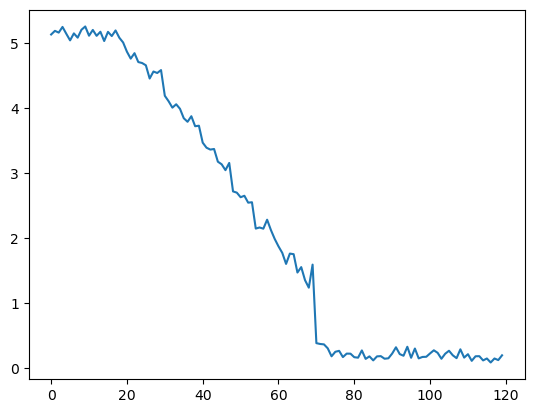

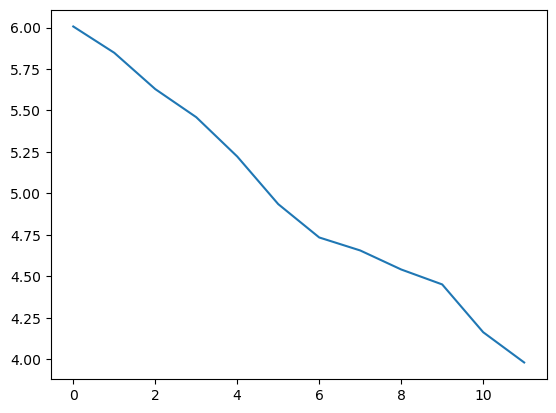

In [25]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()

# Retrieve nearest neighbor in the training set using test set data

In [26]:
annots = np.load("/fsx/proj-fmri/shared/mindeyev2_dataset/COCO_73k_annots_curated.npy")

100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.25s/it]

Original Image (test set)


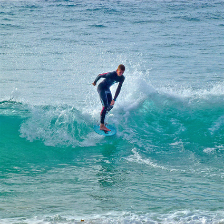

clip_voxels_norm torch.Size([1, 197376])
clip_target_norm torch.Size([934, 197376])

Nearest neighbors in training set


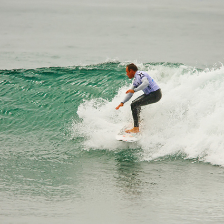

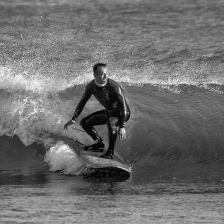

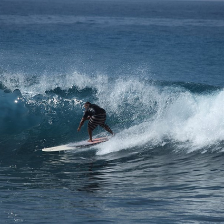

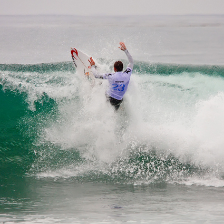

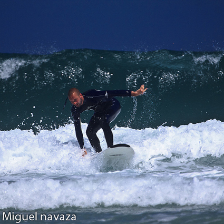


=====
predicted_caption:
 A man is on his surfboard in the ocean water


In [31]:
ii=2
all_indices = np.unique(train_73k_images) #np.hstack((test_vox_indices[ii],train_vox_indices))
with torch.no_grad(), torch.cuda.amp.autocast():
    for batch in tqdm(range(0,len(all_indices),512)):
        if batch==0:
            clip_target = clip_model.embed_image(images[all_indices[batch:batch+512]]).cpu()
        else:
            target = clip_model.embed_image(images[all_indices[batch:batch+512]]).cpu()
            clip_target = torch.vstack((clip_target,target))
    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

    voxel = test_voxel[[ii]].to(device)
    image = test_image[[ii]].to(device)

    print("Original Image (test set)")
    display(utils.torch_to_Image(image))
    
    clip_target = clip_model.embed_image(image).cpu()
    # clip_target_norm = torch.vstack((clip_target_norm, nn.functional.normalize(clip_target.flatten(1), dim=-1)))
    
    voxel_ridge = model.ridge(voxel).unsqueeze(1)
    clip_voxels, _, _ = model.backbone(voxel_ridge)    
    clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
    clip_voxels_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

    print("clip_voxels_norm", clip_voxels_norm.shape)
    print("clip_target_norm", clip_target_norm.shape)
    
    sortt = torch.argsort(utils.batchwise_cosine_similarity(clip_voxels_norm.cpu(), 
                                                            clip_target_norm).flatten()).flip(0)
    picks = all_indices[sortt[:5]]

    print("\nNearest neighbors in training set")
    for ip,p in enumerate(picks):
        display(utils.torch_to_Image(images[[p]]))
        # print(utils.select_annotations([annots[int(p)]]))
        if ip==0: predicted_caption = utils.select_annotations([annots[int(p)]])[0]

print("\n=====\npredicted_caption:\n", predicted_caption)

# Feed into Stable Diffusion XL for reconstructions

In [ ]:
from diffusers import StableDiffusionXLPipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    "/fsx/proj-fmri/shared/cache/models--stabilityai--stable-diffusion-xl-base-1.0/snapshots/f898a3e026e802f68796b95e9702464bac78d76f", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe.to("cuda")
pass

In [ ]:
prompt = predicted_caption
recon = pipe(prompt=prompt).images[0]

In [ ]:
print("Seen image")
display(utils.torch_to_Image(image))

print("Reconstruction")
utils.torch_to_Image(utils.resize(transforms.ToTensor()(recon),224))